<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Uniform-Lévy-walks" data-toc-modified-id="Uniform-Lévy-walks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Uniform Lévy walks</a></span></li><li><span><a href="#Constrained-Lévy-walks" data-toc-modified-id="Constrained-Lévy-walks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Constrained Lévy walks</a></span></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import celluloid
import numpy as np
from sadie import agents, models

## Overview

A Lévy walk is a process (in this case, in two-dimensional Euclidean space) in which the distribution of trip distances follows the Levy distribution

$$ f(x) = \frac{e^{-\frac{1}{2x}}}{\sqrt{2 \pi x^3}} $$

and trip azimuths are generally determined using a uniform distribution over $(0, 2\pi]$.

Sadie implements a range of Lévy walkers:

* [Uniform Lévy walker](https://sadie.readthedocs.io/en/latest/walkers.html#the-uniform-levy-walker): unbounded Lévy flight with a uniform angular distribution over $(0, 2\pi]$.
* [Bounded uniform Lévy walker](https://sadie.readthedocs.io/en/latest/walkers.html#the-bounded-uniform-levy-walker): takes a bounding distribution, a scaling factor and optional parameters of the bounding distribution, and determines retargeting based on the distribution.
* [Homesick Lévy walkers](https://sadie.readthedocs.io/en/latest/walkers.html#homesick-levy-walkers): implementing the homesick Lévy walk concept from [Fujihara and Miwa (2014)](https://arxiv.org/abs/1408.0427) in two ways – stepwise retargeting and tripwise retargeting.

## Uniform Lévy walks

In [2]:
%%time

m = models.simple.SimpleModel(max_time=1000)

m.add_agent(agents.walkers.UniformLevyRandomWalker(*np.random.randint(-100, 100, 2)))

%time
m.run()

df = m.to_df()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.01 µs
CPU times: user 104 ms, sys: 3.56 ms, total: 108 ms
Wall time: 205 ms


CPU times: user 5.19 s, sys: 609 ms, total: 5.8 s
Wall time: 9.92 s


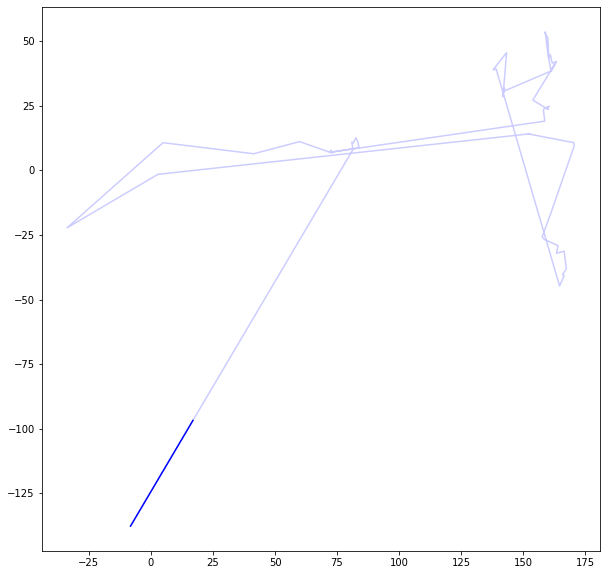

In [3]:
%%time

from celluloid import Camera
from IPython.display import HTML
from math import floor

fig = plt.figure(figsize=(10, 10))
cam = Camera(fig)

for i in range(df.time.min(), df.time.max()):
    if i % 10 == 0:
        subdf = df[df.time < i]
        plt.plot(subdf.x, subdf.y, "b-", alpha=0.2)
        plt.plot(subdf.x[-1 * floor(df.time.max() / 20):], subdf.y[-1 * floor(df.time.max() / 20):], "b-", alpha=1)
        cam.snap()

HTML(cam.animate().to_html5_video())

## Constrained Lévy walks

A constrained Lévy walk uses a probability distribution to determine whether to retarget or not. For an agent $a_i \in A$ at time $t$, $a_i$ will retarget if and only if $P(*) > \hat{d}(a_i, t)$, where $\hat{d}(a_i, t)$ is the current trip length at time $t$ and $P(*)$ is the probability distribution conditioned by the parameters $*$. Any distribution that implements `scipy.stats.rv_continuous` can be used.

Consider the following constrained random walker, based on `BoundedUniformLevyRandomWalker`, with a `gamma` distribution $\Gamma(x, 10)$. The $\Gamma$ distribution is passed in via `scipy.stats.gamma` and `a = 10` is passed in as its generative parameter.

In [4]:
from scipy.stats import gamma

m = models.simple.SimpleModel(max_time=1000)
agt = agents.walkers.BoundedUniformLevyRandomWalker(x_init=np.random.randint(-100, 100),
                                                          y_init=np.random.randint(-100, 100),
                                                          bounding_distribution=gamma,
                                                          a = 10)
m.add_agent(agt)
    
%time
m.run()

df = m.to_df()

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 7.15 µs


CPU times: user 10.5 s, sys: 1.13 s, total: 11.6 s
Wall time: 20.3 s


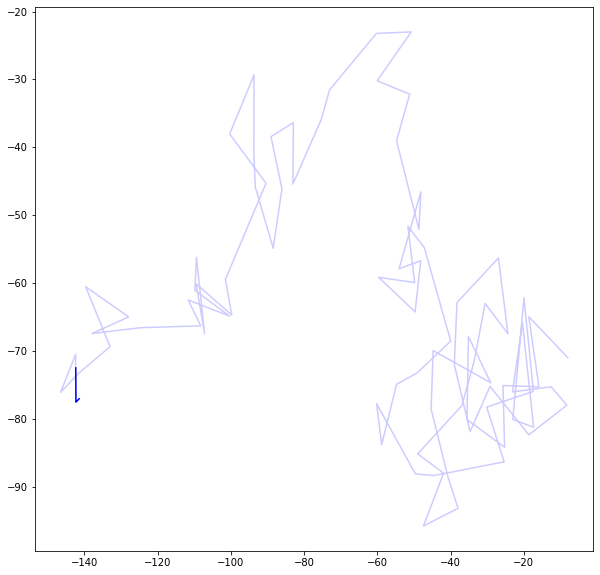

In [5]:
%%time

fig = plt.figure(figsize=(10, 10))
cam = Camera(fig)

for i in range(df.time.min(), df.time.max()):
    if i % 5 == 0:
        subdf = df[df.time < i]
        plt.plot(subdf.x, subdf.y, "b-", alpha=0.2)
        plt.plot(subdf.x[-1 * floor(df.time.max() / 100):], subdf.y[-1 * floor(df.time.max() / 100):], "b-", alpha=1)
        cam.snap()

HTML(cam.animate().to_html5_video())

<AxesSubplot:>

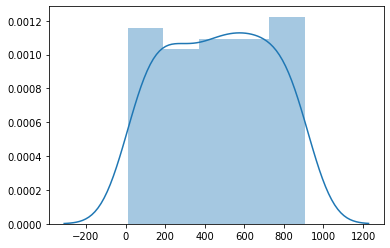

In [6]:
sns.distplot(df.groupby(["tx", "ty"]).agg({"td": max}))

Note that you can reproduce the original Levy behaviour by passing in `scipy.stats.levy()`:

In [7]:
from scipy.stats import levy

m = models.simple.SimpleModel(max_time=1000000)
agt = agents.walkers.BoundedUniformLevyRandomWalker(x_init=np.random.randint(-100, 100),
                                                          y_init=np.random.randint(-100, 100),
                                                          bounding_distribution=levy, scale_factor=10)
m.add_agent(agt)
    
%time
m.run()

df = m.to_df()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


<AxesSubplot:>

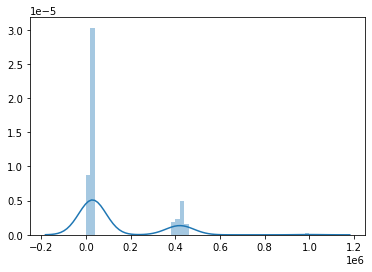

In [8]:
sns.distplot(df.groupby(["tx", "ty"]).agg({"td": max}))